In [42]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
import torch
import numpy as np
import scipy as sp
import math
import copy
import pandas as pd
from matplotlib import pyplot as plt
from dataclasses import dataclass
from tqdm import tqdm

from test_sampler import TestProblem, TestProblem2
from optimize_algos import test_algo_by_problem, ACRCD, ACRCD_star, just_USTM

## TEST ACRCD

In [106]:
problem_1 = TestProblem(x_dim=10, y_dim=200, gamma=1e-3, La=1e-1, svxpy_verbose=True)
print(f"{problem_1.Lx=}, {problem_1.Ly=}")

                                     CVXPY                                     
                                     v1.3.2                                    
(CVXPY) Jul 19 10:31:45 AM: Your problem has 210 variables, 0 constraints, and 0 parameters.
(CVXPY) Jul 19 10:31:46 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) Jul 19 10:31:46 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) Jul 19 10:31:46 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) Jul 19 10:31:46 AM: Compiling problem (target solver=SCS).
(CVXPY) Jul 19 10:31:46 AM: Reduction chain: Dcp2Cone -> CvxAttr2Constr -> ConeMatrixStuffing ->

In [107]:
# x = np.zeros(problem_1.x_dim)
# # x = np.ones(problem_1.x_dim)
# y = np.zeros(problem_1.y_dim)
# problem_1.calc(x, y)

## TEST USTM

100%|██████████| 3000/3000 [00:05<00:00, 533.40it/s]


start f val:  5.866284
result val:  -0.31049168
grad norm:  0.0007848498
solver/analytic f*:  -0.3078019574537143
start, end L:  0.09375855326652527 12.001094818115234


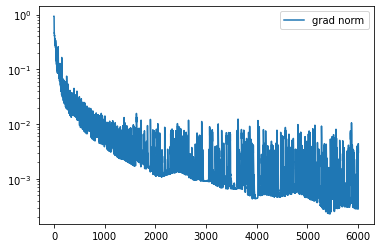

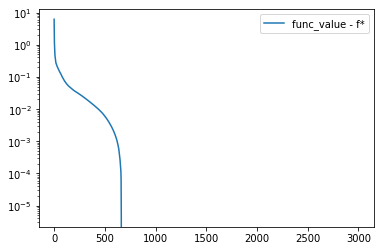

In [108]:
test_problem = problem_1

x0 = np.ones(test_problem.x_dim + test_problem.y_dim)
t_history, value_log, ustm_grad_history, A_log, (start_L, L_value) = \
    just_USTM(test_problem, x0,
              eps_abs=1e-7,
              max_iter=3000)

res_f, grad = test_problem.calc_by_one_block(t_history[-1])

print("start f val: ", value_log[0])
print("result val: ", res_f)
print("grad norm: ", np.linalg.norm(grad))
print("solver/analytic f*: ", test_problem.f_star)
print("start, end L: ", start_L, L_value)

plt.plot(ustm_grad_history, label='grad norm')
plt.yscale("log")
plt.legend()
plt.show()

plt.plot(np.array(value_log) - test_problem.f_star, label="func_value - f*")
plt.yscale("log")
plt.legend()
plt.show()

## TESTING ACRCD

100%|██████████| 12000/12000 [00:05<00:00, 2199.82it/s]


start f val:  -0.005977887660264969
result val:  -0.31042865
grad x norm:  0.00015550644
grad y norm:  0.00029099308
solver/analytic f*:  -0.3078019574537143
start, end L1:  50 50
start, end L2:  0.1 0.1


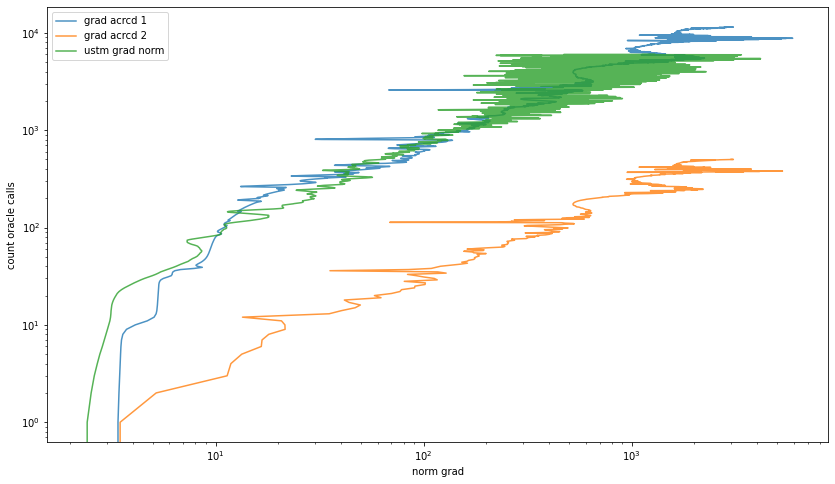

In [111]:
test_problem = problem_1
L1_init=50
L2_init=problem_1.Ly


# K = 6000

x0 = np.zeros(test_problem.x_dim)
y0 = np.zeros(test_problem.y_dim)

(history, history_first_oracle, history_second_oracle),\
grad_x_norms, grad_y_norms, \
x1_list_ACRCD, x2_list_ACRCD, (L1, L2) = \
    ACRCD(test_problem,x0, y0, K=12000, L1_init=L1_init, L2_init=L2_init)

res_f, grad_x, grad_y = test_problem.calc(x1_list_ACRCD[-1], x2_list_ACRCD[-1])

print("start f val: ", history[0])
print("result val: ", res_f)
print("grad x norm: ", np.linalg.norm(grad_x))
print("grad y norm: ", np.linalg.norm(grad_y))
print("solver/analytic f*: ", test_problem.f_star)
print("start, end L1: ", L1_init, L1)
print("start, end L2: ", L2_init, L2)

# plt.plot(grad_x_norms, label='acrcd x grad norm',  alpha=ALPHA)
# plt.plot(grad_y_norms, label='acrcd y grad norm',  alpha=ALPHA)
# plt.plot(ustm_grad_history, label='ustm grad norm',  alpha=ALPHA)
# plt.yscale("log")
# plt.legend()
# plt.show()
#
# plt.plot(history-test_problem.f_star, label="func_value - f*")
# plt.yscale("log")
# plt.legend()
# plt.show()
plt.figure(figsize=(14, 8))
ALPHA = 0.8

def get_rotated_values(values):
    return 1/np.array(values), range(len(values))

def plot_to_csv(x, y, csv_name):
    data = list(zip(x, y))
    if len(data) > 500:
        step = len(data) // 200
        data = [data[i] for i in range(0, len(data), step)]

    x, y = list(zip(*data))
    df = pd.DataFrame({"x":x, "y":y})
    df.to_csv(csv_name, index=False)

w = 10
ustm_grad_history = np.convolve(ustm_grad_history, np.ones(w) / w, "valid")

plt.plot(*get_rotated_values(history_first_oracle), label="grad acrcd 1", alpha=ALPHA)
plt.plot(*get_rotated_values(history_second_oracle), label="grad acrcd 2", alpha=ALPHA)
plt.plot(*get_rotated_values(ustm_grad_history), label='ustm grad norm', alpha=ALPHA)

plot_to_csv(*get_rotated_values(history_first_oracle), csv_name="test_problem_first_oracle.csv")
plot_to_csv(*get_rotated_values(history_second_oracle), csv_name="test_problem_second_oracle.csv")
plot_to_csv(*get_rotated_values(ustm_grad_history), csv_name="test_problem_ustm.csv")

plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel("norm grad")
plt.ylabel("count oracle calls")
plt.show()

In [52]:
# # test_algo_by_problem(test_problem=problem_1, algo_func=ACRCD_star, L1_init=problem_1.Lx, L2_init=problem_1.Ly, k=500)
# test_algo_by_problem(test_problem=problem_1, algo_func=ACRCD, L1_init=50, L2_init=problem_1.Ly, k=int(1e4))
# # test_algo_by_problem(test_problem=problem_1, algo_func=ACRCD_star, L1_init=problem_1.Lx, L2_init=problem_1.Ly, k=3000)

100%|██████████| 3000/3000 [00:06<00:00, 492.16it/s]


start f val:  6.4903393
result val:  -0.29176414
grad norm:  0.00077991816
solver/analytic f*:  -0.2889054662200201
start, end L:  0.10082528591156006 25.811273193359376


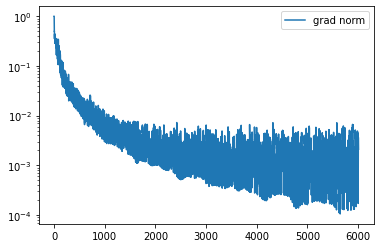

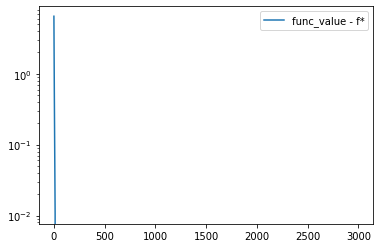

# Вторая задача (решается аналитически) = не актуально

## ACRCD - правильные L

In [ ]:
problem_2 = TestProblem2(La=100, Lb=10)

In [ ]:
test_algo_by_problem(test_problem=problem_2, algo_func=ACRCD, L1_init=problem_2.La, L2_init=problem_2.Lb)

## ACRCD - неправильные L

In [ ]:
test_algo_by_problem(test_problem=problem_2, algo_func=ACRCD, L1_init=problem_2.La/2, L2_init=problem_2.Lb)

## ACRCD* - неправильные L

In [ ]:
test_algo_by_problem(test_problem=problem_2, algo_func=ACRCD_star, L1_init=problem_2.La/2, L2_init=problem_2.Lb)

# Первая задача (решается солвером)
# ACRCD

In [ ]:
test_algo_by_problem(test_problem=problem_1, algo_func=ACRCD, L1_init=100, L2_init=100)

In [ ]:
test_algo_by_problem(test_problem=problem_1, algo_func=ACRCD_star, L1_init=100, L2_init=100)